In [1]:
import scipy as sp
import collections
from scipy.spatial import distance_matrix
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Point
import json
import sklearn
from sklearn.neighbors import NearestNeighbors
import sklearn.preprocessing as preprocessing
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from convertbng.util import convert_bng, convert_lonlat

# Effective Amenity 
For amenity $i$
$$A_i = \sum_{j=1}^{N_c} \mathrm{e}^{-\gamma d_ij} =\sum_{j=1}^{k}\mathrm{e}^{-\gamma d_ij} + \sum_{j=k+1}^{N_c}\mathrm{e}^{-\gamma d_ij} = \sum_{j=1}^{k}\mathrm{e}^{-\gamma d_ij}+\epsilon $$


#### about $\gamma$ calibration not clear...
To calibrate $\gamma$, choose $\gamma$ s.t. $\Delta d = \frac{2}{\gamma}$ is the distance that at which contribution of another amenity i to amenity j is halved. Hidalgo chose $\Delta d = 62.5 m $ hence $\gamma = 16$   

$k$ is the nearest k neighbor and Hidalgo chose 2000.


In [2]:
# function for effective amenities
# input -- indice matrix and distance matrix
# parameter gamma
def effectiveAmenities(ind_matrix,dist_matrix,gamma):
    # grope dimension of the indice matrix
    N_c = len(ind_matrix) # total number of amenities
    k = len(ind_matrix[0])-1  # k is number of nearest neighbor examined.
    
    # set up storage of computed data
    A_i_arr = [] # declaring an empty array to store effective amenities for each i
    
    # calculate A_i for each i
    for i in range(0,N_c):
        A_i_temp =0
        
        # loop through all k nearest neighbors 
        for j in range(1,k+1):
            
            # contribution each neighbor has to j's effective amenity pairwise
            j_to_i = math.exp(-gamma*dist_matrix[i][j])    
            A_i_temp = A_i_temp + j_to_i
            
        A_i_arr.append(A_i_temp)
    
    return(A_i_arr)
            


# Definition of cluster centers: 
if amenity i has higher $A_i$ that is higher than its $n_i$ neighbors and somehow, Hidalgo defined $n_i$ as:
$$n_i = 3 A_i + 50 $$

well, for the general form
$$n_i = a A_i + b $$
$a$ bigger -> more likely to identify "centers" in the middle of nowhere

$b$ smaller -> want more centers

but the calibration depends on the scale of the actual data

In [3]:
def idClusterCenters(A_i_arr,indices):
    # get the ni defined above, number of closest neighbors for each i to be examined.
    n_i_arr = np.add(np.multiply(A_i_arr,3),50).astype(int)  
    print(n_i_arr)
    # set up storage of binary judgment value
    is_cluster_center_arr = []
    
    for i in range(0,len(A_i_arr)):
        
        i_is_cluster_center = True
        # for amenity i, its n_i closest neighbors are indices[i][1:n_i_arr +1]
        i_ni_nearest_neighbors_indices = indices[i][1:n_i_arr[i] +1] # array of indices of nodes that are i's nearest neighbor
        
        for j in range(0,len(i_ni_nearest_neighbors_indices)):
            if A_i_arr[i_ni_nearest_neighbors_indices[j]] > A_i_arr[i]: 
                i_is_cluster_center = False
        
        is_cluster_center_arr.append(i_is_cluster_center)
    return(is_cluster_center_arr)    

# ------------------------------------
# I. Data Preparation
### (a) json -> df
These code to open and convert json file into dataframe is from Lefteri

In [4]:
#Do not run unless you have time...
with open('/Users/June/urbanDNA/Ele-June/horizontal2.json') as json_data: # in f+p we need to add in the parenthesis the parameter   ,encoding="utf8"
    json_dic_data = json.load(json_data)
json_list_data = json_dic_data['elements']    
labels = ['id', 'lat', 'lon', 'amenity'] # make a list with the columns that you want in your dataframe
df = pd.DataFrame.from_records(json_list_data, columns=labels)
df.head()

,id,lat,lon,amenity
0,108042,51.523544,-0.135599,NaN
1,109575,51.528262,-0.143121,NaN
2,13799212,51.521079,-0.115632,NaN
3,15262028,51.516395,-0.169763,NaN
4,20821133,51.500393,-0.177711,NaN


In [5]:
new_list=[]
for i in range(len(json_list_data)):
    new_list.append(json_list_data[i]['tags']['amenity']) 

df['amenity'] = new_list

In [6]:
df.head()

,id,lat,lon,amenity
0,108042,51.523544,-0.135599,pub
1,109575,51.528262,-0.143121,advice
2,13799212,51.521079,-0.115632,library
3,15262028,51.516395,-0.169763,pub
4,20821133,51.500393,-0.177711,pub


### (b) df --> gdf  
for plotting for example

In [7]:
# ### First, from geopandas import GeoDataFrame, and viz
# dff = df
# geometry = [Point(xy) for xy in zip(dff.lon, dff.lat)]
# dff = dff.drop(['lon', 'lat'], axis=1)
# crs = {'init': 'WGS84'} ## double check if the json is in WGS84
# geo_dff = gpd.GeoDataFrame(dff, crs=crs, geometry=geometry)
# geo_dff

### (c) re-project into BNG 
in order to calculate distance

In [8]:
n_e_list = convert_bng(df['lon'], df['lat'])
df_BNG = df.drop(['lon', 'lat'], axis=1)
df_BNG['est'] = n_e_list[0]
df_BNG['nor']= n_e_list[1]
df_BNG.head() ### bng, pd.DataFrame

,id,amenity,est,nor
0,108042,pub,529440.033,182161.332
1,109575,advice,528904.893,182672.735
2,13799212,library,530832.236,181922.664
3,15262028,pub,527090.013,181306.459
4,20821133,pub,526582.847,179513.316


### (d) df_BNG -> geo_df_BNG

In [9]:
# dff_BNG = df_BNG
# geometry = [Point(xy) for xy in zip(dff_BNG.nor, dff_BNG.est)]
# dff_BNG = dff_BNG.drop(['nor', 'est'], axis=1)
# crs = {'init': 'OSGB36'} 
# geo_df_BNG = gpd.GeoDataFrame(dff_BNG, crs=crs, geometry=geometry)
# geo_df_BNG ### bng, gpd.GeoDataFrame

,id,amenity,geometry
0,108042,pub,POINT (182161.332 529440.0330000001)
1,109575,advice,POINT (182672.735 528904.893)
2,13799212,library,POINT (181922.664 530832.236)
3,15262028,pub,POINT (181306.459 527090.013)
4,20821133,pub,POINT (179513.316 526582.847)
5,21392280,pub,POINT (181319.7 531590.8149999999)
6,21593232,pub,POINT (181290.514 531118.513)
7,21593236,pub,POINT (181488.835 530595.446)
8,21593237,bar,POINT (181501.684 530612.242)
9,21593238,pub,POINT (181388.844 530589.846)


# II. Clusterring
## A. Effective number of amenities
### (a) Finding k nearest neighbors

In [9]:
X=df_BNG.as_matrix(columns=df_BNG.columns[2:4])
nbrs = NearestNeighbors(n_neighbors=2001, algorithm='auto').fit(X) 
#2001 nearest neighbors bc the algorithm includes the node itself
distances, indices = nbrs.kneighbors(X)

In [10]:
# # indices and distances are matrices / nested arrays ## actually scratch paper material
# indices
# indices[0][1:4]


In [11]:
# indices_df =pd.DataFrame(indices)
# indices_df.head()

### (b) Find effective amenities $A_i$ for each amenity

In [12]:
#Do not run unless you have time...

A_i_arr = effectiveAmenities(indices,distances,0.005)
# but, should find ways to calibrate this... according to the actual meaning

In [13]:
A_i_arr_view = np.around(A_i_arr,3)

In [14]:
df_BNG['Ai']=A_i_arr_view

# df_BNG['Ai_log']=np.log10(A_i_arr)
# df_BNG = df_BNG.drop(['Ai_log'], axis=1)
df_BNG.head()
# help(math.log)

,id,amenity,est,nor,Ai
0,108042,pub,529440.033,182161.332,48.571
1,109575,advice,528904.893,182672.735,16.969
2,13799212,library,530832.236,181922.664,55.987
3,15262028,pub,527090.013,181306.459,32.968
4,20821133,pub,526582.847,179513.316,14.246


### (c) Mapping $A_i$
always viz to check if the result makes sense, right?

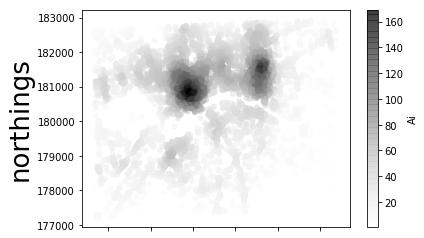

In [15]:
df_BNG.plot.scatter(x='est', y='nor',c='Ai',cmap='', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.ylabel('northings', fontsize=26)
plt.xlabel('eastings', fontsize=26)
plt.show()

## B. Identifying cluster centers

In [16]:
results =idClusterCenters(A_i_arr,indices)

[195 100 217 ..., 509 508 145]


In [17]:
df_BNG['centers']=results
df_BNG.head()
df_BNG[df_BNG['centers']]
# print(df["Ai"].max())

## hence, it's only getting the biggest. 

,id,amenity,est,nor,Ai,centers
682,300425808,restaurant,526736.717,178749.248,37.996,True
1538,534654080,restaurant,525841.448,180919.003,49.083,True
1928,624046571,bank,529739.808,180840.037,169.039,True
2482,847077749,bicycle_rental,531341.083,181582.225,76.275,True
2966,1184333834,cafe,532029.447,178900.567,29.061,True
3623,1932743655,cafe,536392.736,182467.546,26.128,True
4003,2499646632,currency_exchange,528942.677,179028.852,63.506,True
4183,2707252360,cafe,531212.483,178198.710,27.633,True
5161,3714081146,sauna,531136.398,179723.194,50.269,True
5728,3961202763,post_office,533210.453,181595.207,147.446,True


In [18]:
pd.Series.value_counts(df_BNG['centers'])

False    6641
True       10
Name: centers, dtype: int64

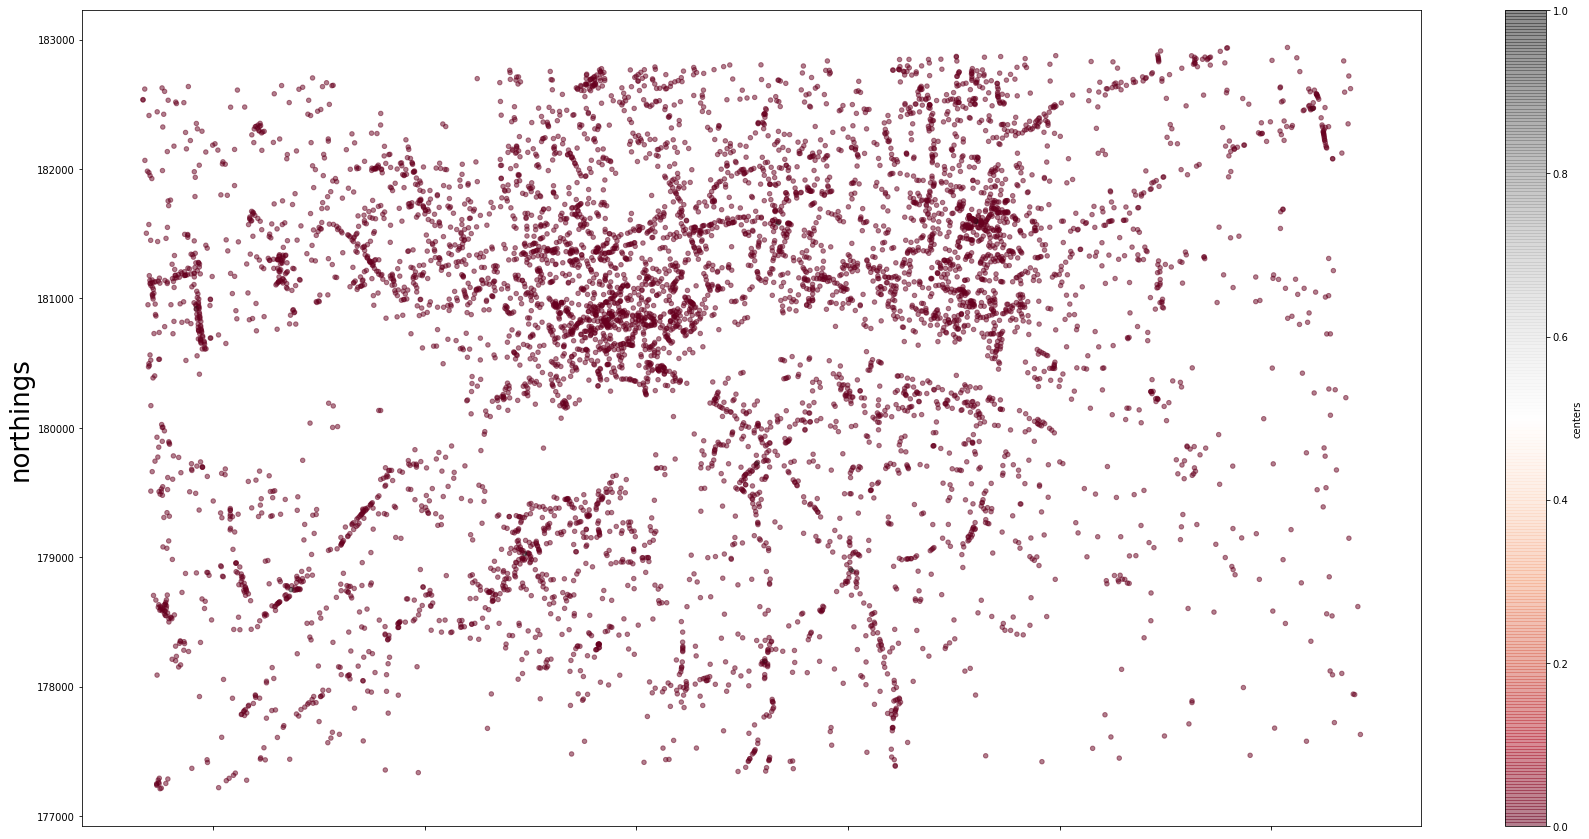

In [19]:
df_BNG.plot.scatter(x='est', y='nor',c='centers',figsize=(30,15),cmap='RdGy', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.xlabel('eastings', fontsize=26)
plt.ylabel('northings', fontsize=26)
plt.show()

## C. Assigning points to clusters
### (a) remove 10% of points with lowest $A_i$

In [20]:
threshold_10 = np.percentile(df_BNG['Ai'], 10) # threshold of the lowest 10%
df_BNG_90=df_BNG[df_BNG['Ai']> threshold_10]
pd.Series.value_counts(df_BNG_90['centers']) # check if centers were removed as outlier, not that it matters...

False    5975
True       10
Name: centers, dtype: int64

### (b) set up data structure for clustering

In [21]:
# set up label column to show what cluster each point belongs to. -2 means unassigned yet.
# didn't use -1 because -1 is by convention the outlier label 

df_BNG_90['label'] = np.full((len(df_BNG_90),1),-2) 
df_BNG_90.head()



/Users/June/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,id,amenity,est,nor,Ai,centers,label
0,108042,pub,529440.033,182161.332,48.571,False,-2
1,109575,advice,528904.893,182672.735,16.969,False,-2
2,13799212,library,530832.236,181922.664,55.987,False,-2
3,15262028,pub,527090.013,181306.459,32.968,False,-2
5,21392280,pub,531590.815,181319.700,67.382,False,-2


In [22]:
### get centers' information
centers_df = df_BNG_90[df_BNG_90.centers == True]
num_clusters = len(centers_df)
center_index_arr = df_BNG_90.index[df_BNG_90.centers == True].values

## get border points' (non-centers) information
border_points_df=df_BNG_90[df_BNG_90.label == -2]
border_points_index_arr = df_BNG_90.index[df_BNG_90.centers==False].values

### fill the cluster centers' labels
for i in range(0,num_clusters):
    df_BNG_90.set_value(center_index_arr[i],'label',i)
    
centers_df


,id,amenity,est,nor,Ai,centers,label
682,300425808,restaurant,526736.717,178749.248,37.996,True,-2
1538,534654080,restaurant,525841.448,180919.003,49.083,True,-2
1928,624046571,bank,529739.808,180840.037,169.039,True,-2
2482,847077749,bicycle_rental,531341.083,181582.225,76.275,True,-2
2966,1184333834,cafe,532029.447,178900.567,29.061,True,-2
3623,1932743655,cafe,536392.736,182467.546,26.128,True,-2
4003,2499646632,currency_exchange,528942.677,179028.852,63.506,True,-2
4183,2707252360,cafe,531212.483,178198.710,27.633,True,-2
5161,3714081146,sauna,531136.398,179723.194,50.269,True,-2
5728,3961202763,post_office,533210.453,181595.207,147.446,True,-2


In [23]:
## scratch paper
centers_df.id.values # that's how to retrieve the value array of a panda series!
geo_df_BNG[geo_df_BNG.id == 300425808] # that's how to access one row with value of one column
centers_df.loc[682,"label"]

NameError: name 'geo_df_BNG' is not defined

### (b) initialize by assigning points within 0.5 km radius of the identified center to the clusters.

In [36]:
# ## create an array of gpd centers
# centers_gdf = []
# # buffers = gpd.GeoDataFrame()
# # i = 0
# for x in centers_df.id.values:
#     centers_gdf.append(geo_df_BNG[geo_df_BNG.id == x])
# #     buffers.append(centers_gdf[i].buffer(5))
# #     i+=1
# centers_gdf
# # buffers

In [37]:
centers_df

,id,amenity,est,nor,Ai,centers,label
682,300425808,restaurant,526736.717,178749.248,37.996,True,-2
1538,534654080,restaurant,525841.448,180919.003,49.083,True,-2
1928,624046571,bank,529739.808,180840.037,169.039,True,-2
2482,847077749,bicycle_rental,531341.083,181582.225,76.275,True,-2
2966,1184333834,cafe,532029.447,178900.567,29.061,True,-2
3623,1932743655,cafe,536392.736,182467.546,26.128,True,-2
4003,2499646632,currency_exchange,528942.677,179028.852,63.506,True,-2
4183,2707252360,cafe,531212.483,178198.710,27.633,True,-2
5161,3714081146,sauna,531136.398,179723.194,50.269,True,-2
5728,3961202763,post_office,533210.453,181595.207,147.446,True,-2


In [95]:
initialization = df_BNG_90.copy()
r = 400
for i in range(0,len(center_index_arr)):
    
    for j in range (0,len(border_points_index_arr)):
        dx = centers_df.loc[center_index_arr[i],"est"] - border_points_df.loc[border_points_index_arr[j],"est"]
        dy = centers_df.loc[center_index_arr[i],"nor"] - border_points_df.loc[border_points_index_arr[j],"nor"]
        
        if math.hypot(dx, dy)<r:
            initialization.set_value(border_points_index_arr[j],'label',i)
    

In [61]:
pd.Series.value_counts(initialization['label']) 
# To see distribution of assiging. most are not assigned. 
# to speed up the process, enlarge radius to 800 meter.


-2    4586
 2     369
 9     293
 3     164
 6     133
 8     117
 1     114
 0      61
 7      50
 5      49
 4      49
Name: label, dtype: int64

### (c) Viz result of initialization

NB.color for -2 is the unassigned ones

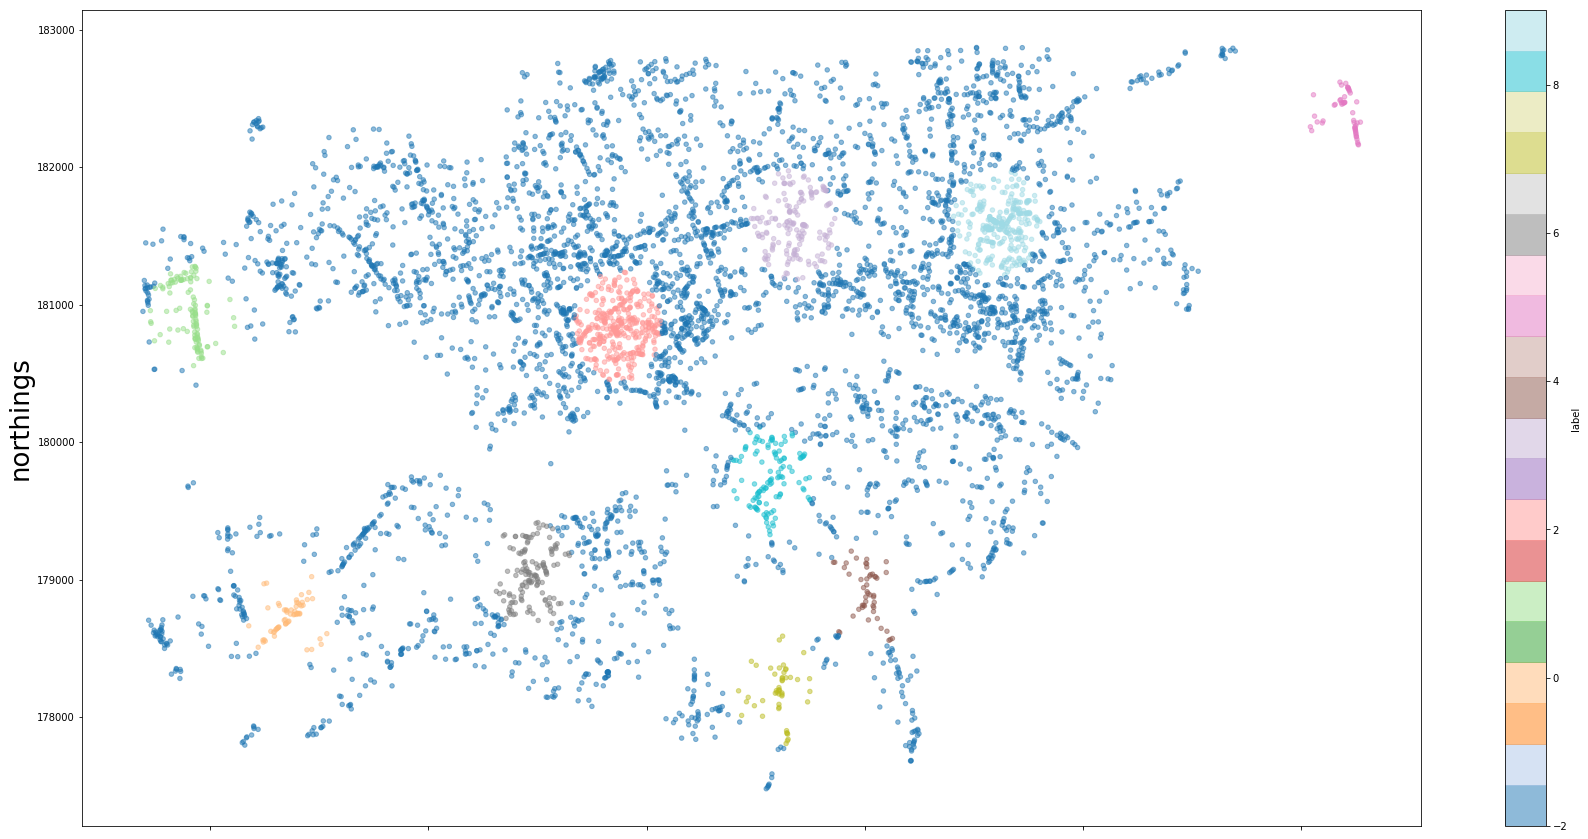

In [50]:
initialization.plot.scatter(x='est', y='nor',c='label',figsize=(30,15),cmap='tab20', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.ylabel('northings', fontsize=26)
plt.xlabel('eastings', fontsize=26)
plt.show()

### (d) assign rest of the points 

In [96]:
### trying to get smarter
def assignPoints (input_df):
    
    
    unassigned_points = input_df[input_df.label == -2]
    unassigned_points_coords = unassigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
    unassigned_points_coords = pd.DataFrame.as_matrix(unassigned_points_coords)

    assigned_points = input_df[input_df.label != -2]
    assigned_points_coords = assigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
    assigned_points_coords = pd.DataFrame.as_matrix(assigned_points_coords)

    distmatrix = distance_matrix(assigned_points_coords,unassigned_points_coords)
    distmatrix_df = pd.DataFrame(distmatrix)

    num_rows =len(distmatrix)
    min_dists =  [99999] * len(unassigned_points)



    for i in range(0,num_rows):
        a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
#         cols_for_min_2[i]=a_0
        

        if max(distmatrix[i,:]) < min_dists[a_0]:
# 

            min_dists[a_0] = distmatrix[i,a_0]
            input_df.set_value(unassigned_points.iloc[[a_0]].index.values,'label',assigned_points.iloc[[i]].label.values) 
            
    print(collections.Counter(input_df.label)) # after assignment (assign popular ones to the last occurrence)
    

In [97]:
start=datetime.now()

#Statements

for x in [0,1,2,3,4,5]:
    assignPoints(initialization)
    

print datetime.now()-start

Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4314, 2: 423, 9: 343, 3: 203, 6: 160, 8: 146, 1: 139, 0: 78, 4: 66, 7: 62, 5: 51})
Counter({-2: 4152, 2: 457, 9: 373, 3: 225, 6: 176, 8: 162, 1: 150, 0: 91, 4: 79, 7: 68, 5: 52})
Counter({-2: 3985, 2: 489, 9: 406, 3: 250, 6: 194, 8: 178, 1: 162, 0: 105, 4: 88, 7: 74, 5: 54})
Counter({-2: 3798, 2: 528, 9: 443, 3: 280, 6: 213, 8: 191, 1: 178, 0: 119, 4: 96, 7: 81, 5: 58})
Counter({-2: 3624, 2: 569, 9: 476, 3: 308, 6: 233, 8: 205, 1: 190, 0: 129, 4: 105, 7: 86, 5: 60})
0:00:06.209415


###  This is the iteration while loop

In [99]:
count = 0

while collections.Counter(initialization.label)[-2]>0:
    assignPoints(initialization)
    count = count + 1
    print('This is iteration number: '+ str(count))


Counter({-2: 3231, 2: 655, 9: 550, 3: 374, 6: 278, 8: 239, 1: 209, 0: 162, 4: 119, 7: 104, 5: 64})
This is iteration number: 1
Counter({-2: 3013, 2: 701, 9: 590, 3: 412, 6: 303, 8: 257, 1: 223, 0: 180, 4: 127, 7: 113, 5: 66})
This is iteration number: 2
Counter({-2: 2800, 2: 743, 9: 633, 3: 448, 6: 329, 8: 273, 1: 238, 0: 200, 4: 135, 7: 118, 5: 68})
This is iteration number: 3
Counter({-2: 2597, 2: 786, 9: 674, 3: 480, 6: 350, 8: 295, 1: 247, 0: 217, 4: 143, 7: 125, 5: 71})
This is iteration number: 4
Counter({-2: 2378, 2: 834, 9: 716, 3: 515, 6: 375, 8: 323, 1: 259, 0: 231, 4: 150, 7: 130, 5: 74})
This is iteration number: 5
Counter({-2: 2159, 2: 872, 9: 767, 3: 551, 6: 400, 8: 346, 1: 272, 0: 243, 4: 161, 7: 136, 5: 78})
This is iteration number: 6
Counter({-2: 1957, 2: 908, 9: 817, 3: 586, 6: 420, 8: 370, 1: 283, 0: 255, 4: 169, 7: 137, 5: 83})
This is iteration number: 7
Counter({-2: 1754, 2: 945, 9: 874, 3: 623, 6: 436, 8: 387, 1: 296, 0: 264, 4: 178, 7: 139, 5: 89})
This is iter

ValueError: attempt to get argmin of an empty sequence

In [112]:
print(count) # how many runs
final_assignment = one_run

35


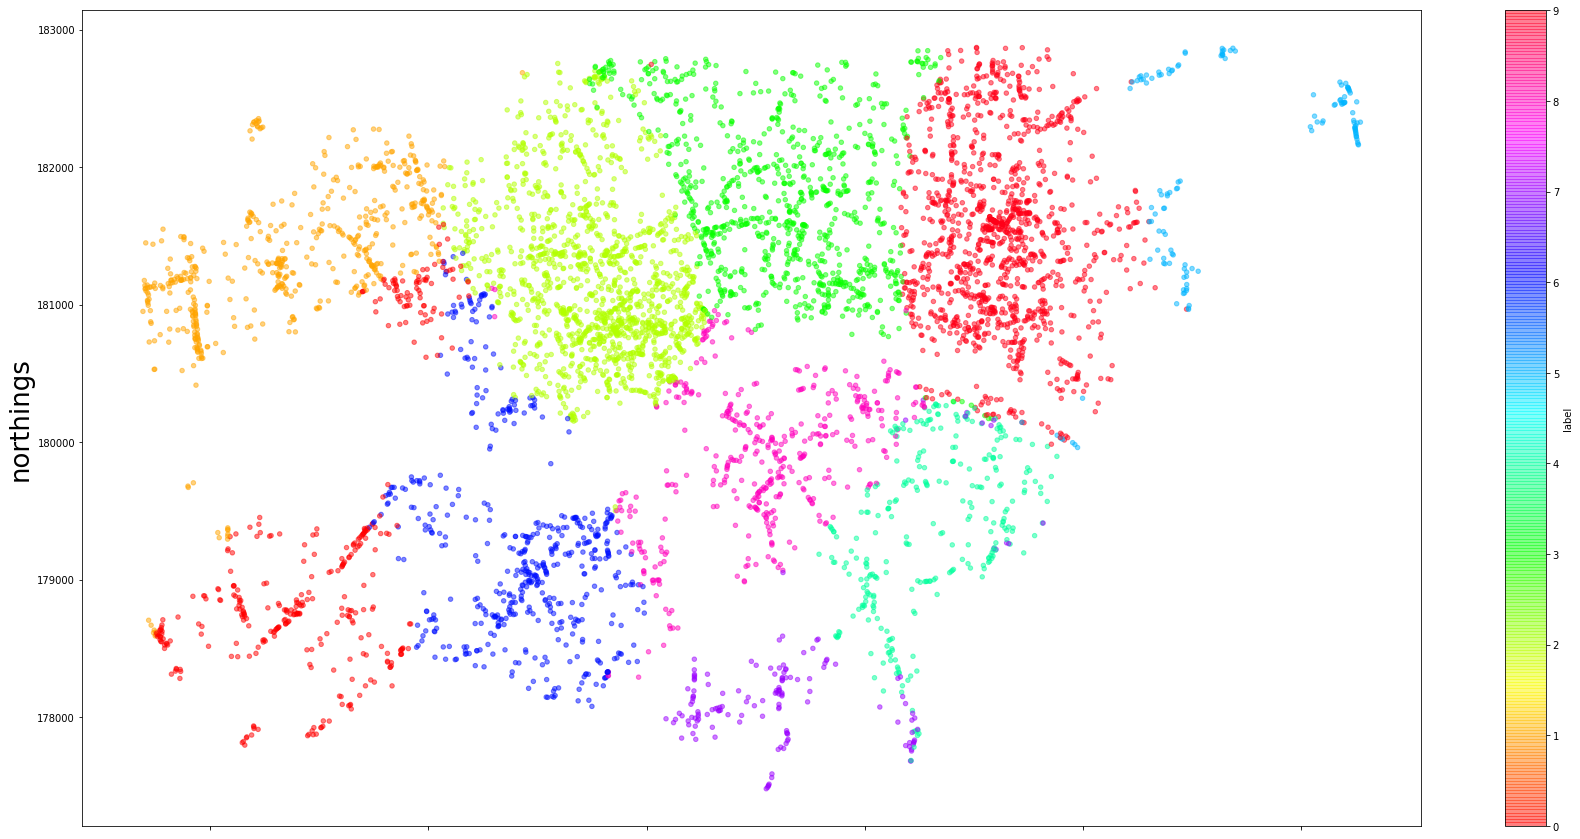

In [100]:
initialization.plot.scatter(x='est', y='nor',c='label',figsize=(30,15),cmap='hsv', alpha=0.5) 
#plt.title('OSM amenities plot', fontsize=30)
plt.ylabel('northings', fontsize=26)
plt.xlabel('eastings', fontsize=26)
plt.show()


# -------------------- Scratch Paper -----------------------

## Toy model for Nearest Neighbors

In [94]:
X_toy = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs_toy = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(X_toy)
# distances, indices = nbrs.kneighbors(X)
# indices 

In [96]:
distances_toy, indices_toy = nbrs_toy.kneighbors(X_toy)
indices_toy

array([[0, 1, 2, 3],
       [1, 0, 2, 3],
       [2, 1, 0, 3],
       [3, 4, 5, 0],
       [4, 3, 5, 0],
       [5, 4, 3, 0]])

In [71]:
distances_toy # hence, first in the array above is the index compared against. the others are its closest neighbors' indices

array([[ 0.        ,  1.        ,  2.23606798,  2.82842712],
       [ 0.        ,  1.        ,  1.41421356,  3.60555128],
       [ 0.        ,  1.41421356,  2.23606798,  5.        ],
       [ 0.        ,  1.        ,  2.23606798,  2.82842712],
       [ 0.        ,  1.        ,  1.41421356,  3.60555128],
       [ 0.        ,  1.41421356,  2.23606798,  5.        ]])

In [98]:
len(indices_toy) # number of amenities in total. Nc

6

In [99]:
len(indices_toy[0]) # returns k+1 where k is the number of nearest neighbor examined

4

In [124]:
indices_toy[2][1]
distances_toy[len(indices_toy)-1][len(indices_toy[0])-1] 

5.0

These are to test if the function works properly on the toy model

In [117]:
N_c = len(indices_toy) # total number of amenities
k = len(indices_toy[0])-1  # k is number of nearest neighbor examined.
print(N_c)
print(k)

6
3


In [125]:
# set up storage of computed data
A_i_arr = [] # declaring an empty array to store effective amenities for each i
gamma =0.02
# calculate A_i for each i
for i in range(0,N_c):
    A_i_temp =0

# loop through all k nearest neighbors 
    for j in range(1,k+1):

# contribution each neighbor has to j's effective amenity pairwise
        j_to_i = math.exp(-gamma*distances_toy[i][j])    
        A_i_temp = A_i_temp + j_to_i

    A_i_arr.append(A_i_temp)
    
A_i_arr            

[1.1765692894986055,
 1.264440065654479,
 0.9020755853708965,
 1.1765692894986055,
 1.264440065654479,
 0.9020755853708965]

In [158]:
A_i_arr_toy=effectiveAmenities(indices_toy,distances_toy,0.5)
A_i_arr_toy

[1.1765692894986055,
 1.264440065654479,
 0.9020755853708965,
 1.1765692894986055,
 1.264440065654479,
 0.9020755853708965]

In [131]:
round(1.8888, 2)

1.89

In [147]:
np.add(1.88,2)

3.8799999999999999

In [183]:
idClusterCenters(A_i_arr_toy)

[False, True, False, False, True, False]

In [177]:

# get the ni defined above
n_i_arr_toy= np.add(np.multiply(A_i_arr_toy,3),50).astype(int) 
print(n_i_arr_toy)
print((A_i_arr_toy))

# set up storage of binary judgment value
# is_cluster_center_arr = []

# for i in range(0,len(A_i_arr_toy)):

#     i_is_cluster_center = True

#     for j in range(0,len(n_i_arr_toy)):
#         if A_i_arr_toy[j] > A_i_arr_toy[i]:
#           # i_is_cluster_center = False
#             print("is not")

#     is_cluster_center_arr.append(i_is_cluster_center)
   

[53 53 52 53 53 52]
[1.1765692894986055, 1.264440065654479, 0.9020755853708965, 1.1765692894986055, 1.264440065654479, 0.9020755853708965]


In [165]:
is_cluster_center_arr

[False, False, False, False, False, False]

In [1022]:
distance_matrix([[0,0],[0,1],[1,1]], [[1,0],[1,1]]) #the first entry is column. second entry is rows

array([[ 1.        ,  1.41421356],
       [ 1.41421356,  1.        ],
       [ 1.        ,  0.        ]])

In [1136]:
### analogy to regular panda. basic stuff....

s = pd.DataFrame(np.random.randn(8, 4), columns=['A', 'B', 'C', 'D'])
s.A[2] ### dataframe.columnName[rowNumber]
s.iloc[1] = dict(A=1,B=2,C=1,D=0)
s=s.drop(["A","B"],axis=1)
# a1 = pd.DataFrame.as_matrix(s.iloc[[0]])[0]
a1= np.asarray(s.iloc[[0]])[0]
a2 = pd.DataFrame.as_matrix(s.iloc[[1]])[0]
a3 =pd.DataFrame.as_matrix(s.iloc[[2]])[0]
a4 = pd.DataFrame.as_matrix(s.iloc[[3]])[0]
dtest = distance_matrix([a1,a2,a3,a4], [a2,a4])

# a1= np.asarray(s.iloc[[0]])


In [1145]:
dtest

array([[ 0.94442848,  1.33167362],
       [ 0.        ,  2.25099916],
       [ 0.90685934,  1.35244155],
       [ 2.25099916,  0.        ]])

In [1152]:
dtest[0] # gives row zero
dtest[0,:] # gives row zero

dtest[:,1] # gives column one

max(dtest[0,:])
len(dtest)  # number of rows!

4

In [1160]:
np.argmax(dtest[3,:])

0

In [1153]:
# vision. a is index (in initialization) of unassigned 
cols_for_max = [] # column numbers of max in each row, in distance matrix
for i in range(0,len(dtest)):
    a_0=np.argmax(dtest[i,:])  # a_0 because it's first stage of getting value a
    cols_for_max.append(a_0)
    
cols_for_max

[1, 1, 1, 0]

In [1162]:
# np.argmax(distmatrix[0,:])
type(distmatrix)


pandas.core.frame.DataFrame

In [1300]:
### scratch paper
i=0
a_0=np.argmin(distmatrix[i,:])
distmatrix[i,a_0]


2838

### These are testings / processes that lead to the recursive assigning points

In [72]:
### unassigned points
unassigned_points = initialization[initialization.label == -2]
unassigned_points_coords = unassigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
unassigned_points_coords = pd.DataFrame.as_matrix(unassigned_points_coords)

print(len(unassigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
unassigned_points_coords

4586


array([[ 529440.033,  182161.332],
       [ 528904.893,  182672.735],
       [ 530832.236,  181922.664],
       ..., 
       [ 530173.625,  180659.96 ],
       [ 526654.082,  181570.016],
       [ 532504.222,  179921.796]])

In [73]:
### assigned points
assigned_points = initialization[initialization.label != -2]
assigned_points_coords = assigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
assigned_points_coords = pd.DataFrame.as_matrix(assigned_points_coords)

print(len(assigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
assigned_points_coords

1399


array([[ 531590.815,  181319.7  ],
       [ 531118.513,  181290.514],
       [ 531638.681,  181470.16 ],
       ..., 
       [ 525879.351,  181188.981],
       [ 530018.168,  180857.576],
       [ 530023.457,  180861.985]])

In [74]:
#### Scratch Paper Stuff ####
# assigned_points['label'].iloc[[0]]
# assigned_points.iloc[[0]].label.values
# assigned_points.iloc[[0]].index
# ## so, within iloc[[SEQUENCE IN NEW DF]] but the index on display / returned by .index are that of  

In [75]:
distmatrix = distance_matrix(assigned_points_coords,unassigned_points_coords)
distmatrix_df = pd.DataFrame(distmatrix)
distmatrix_df # this is for visualization.
#distmatrix

,0,1,2,3,4,5,6,7,8,9,...,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585
0,2309.590361,3007.470815,969.024089,4500.821477,1009.636615,995.350839,1003.354290,363.560943,1165.787410,1944.151936,...,1410.903611,1432.352717,1514.174690,2214.011269,2441.031816,1517.051872,3141.512535,1563.228826,4943.075036,1669.864647
1,1890.930750,2609.721900,693.951110,4028.531555,559.401739,548.546347,537.733750,834.075441,712.779807,2390.899365,...,998.163484,1015.297294,1970.181651,2630.757327,1968.635946,1088.999187,3587.586723,1135.962886,4473.171752,1947.711066
2,2304.728132,2986.600653,924.723422,4551.612746,1043.402138,1026.922969,1051.982485,365.243140,1261.329276,1951.229136,...,1527.269485,1547.153459,1512.890660,2091.432553,2494.804126,1627.485799,3037.979340,1674.160423,4985.599103,1773.863664
3,2351.131517,3048.120269,1006.643145,4542.280055,1051.861552,1037.584495,1045.292555,321.519347,1203.427012,1902.240431,...,1444.157089,1465.974840,1472.012804,2184.599517,2482.445217,1551.620278,3107.141562,1597.655722,4984.904021,1640.784446
4,1906.765932,2608.445764,603.938160,4122.131867,615.314647,599.497413,622.882119,761.656241,870.088751,2347.321118,...,1171.883274,1187.539589,1916.276910,2474.619532,2065.470702,1256.583167,3445.438172,1303.542073,4557.073740,2003.728850
5,2104.460202,2751.027252,691.991316,4449.653716,967.362244,947.377235,1008.761411,675.823759,1316.980874,2207.254953,...,1629.118247,1643.879717,1763.414994,2054.767723,2414.908783,1709.430186,3051.461887,1756.242068,4863.800481,2120.717751
6,3074.882272,3792.954850,2412.649403,4307.804885,2015.134322,2024.359416,1918.587518,2003.417864,1565.222700,2715.110054,...,1326.913587,1348.860632,2501.011094,3892.168680,2573.786194,1415.965388,4634.350134,1415.739056,4814.190929,1549.858931
7,4285.119481,4961.361813,3779.887524,4975.560720,3361.580193,3372.734800,3262.686132,3301.248515,2879.989303,3598.013334,...,2587.741490,2602.757028,3520.039558,5080.133751,3621.447820,2642.933196,5693.112691,2627.500301,5480.120152,2373.679990
8,4149.534676,4883.860006,3236.883752,5481.320019,2944.839295,2948.029323,2860.543786,2372.554394,2588.824786,2301.181899,...,2426.527391,2452.551594,2285.995544,3920.483101,3732.345476,2534.441469,4432.675652,2543.085876,5988.772615,1119.812673
9,1550.233944,2231.535879,1527.230465,2905.887680,1039.370513,1060.005303,960.842327,2107.781939,619.318259,3511.195286,...,412.663737,383.652749,3139.514601,3961.415543,988.072869,282.046411,4915.294292,245.660484,3391.801346,2686.673117


In [82]:
ite_assign = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min = [] # column numbers of min in each row, in distance matrix
for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min.append(a_0) 
    
    a = unassigned_points.iloc[[a_0]].index.values
    b = assigned_points.iloc[[i]].index.values
    b_label = assigned_points.iloc[[i]].label.values
    ite_assign.set_value(a,'label',b_label)   

In [83]:
ite_assign_v2 = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min_2 = np.full((1, len(assigned_points)), 0) # column numbers of max in each row, in distance matrix
cols_for_min_2 = cols_for_min_2[0]
min_dists = np.full((1, len(assigned_points)), 99999999) # a random large value to start with. 
min_dists = min_dists[0]
# min_dists
#cols_for_min_2

for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min_2[i]=a_0
    a = unassigned_points.iloc[[a_0]].index.values
    
    if distmatrix[i,a_0] < min_dists[i]:
        b = assigned_points.iloc[[i]].index.values
        b_label = assigned_points.iloc[[i]].label.values
        
        min_dists[i] = distmatrix[i,a_0]
        ite_assign_v2.set_value(a,'label',b_label)   

In [84]:
# print(collections.Counter(cols_for_min)) # which unassigned points are "popular" (close to many assigned points)
# print(collections.Counter(cols_for_min_2))
print(min_dists)
print(collections.Counter(initialization.label)) # only after initialization, before assign
print(collections.Counter(ite_assign.label)) # after assignment (assign popular ones to the last occurrence)
print(collections.Counter(ite_assign_v2.label)) # after assigining popular ones to the nearest occurence

### but here the results from the last two are the same because all the assigned dots that have the same 

[ 84  53 123 ..., 145 123 117]
Counter({-2: 4586, 2: 369, 9: 293, 3: 164, 6: 133, 8: 117, 1: 114, 0: 61, 7: 50, 4: 49, 5: 49})
Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})


In [85]:
#### if we want to see that the second iterative assign is actually doing something. try THIS
ite_asssign_v2 = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min_2 = np.full((1, len(assigned_points)), 0) # column numbers of max in each row, in distance matrix
cols_for_min_2 = cols_for_min_2[0]
min_dists = np.full((1, len(assigned_points)), 100) # try THIS. 100 because it would affect 
min_dists = min_dists[0]
# min_dists
#cols_for_min_2

for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min_2[i]=a_0
    a = unassigned_points.iloc[[a_0]].index.values
    
    if distmatrix[i,a_0] < min_dists[i]:
        b = assigned_points.iloc[[i]].index.values
        b_label = assigned_points.iloc[[i]].label.values
        
        min_dists[i] = distmatrix[i,a_0]
        ite_asssign_v2.set_value(a,'label',b_label)   

In [87]:
# print(collections.Counter(cols_for_min)) # which unassigned points are "popular" (close to many assigned points)
# print(collections.Counter(cols_for_min_2))
print(min_dists)
print(collections.Counter(initialization.label)) # only after initialization, before assign
print(collections.Counter(ite_assign.label)) # after assignment (assign popular ones to the last occurrence)
print(collections.Counter(ite_asssign_v2.label)) # after assigining popular ones to the nearest occurence

### in a way, showing that the if statement is doing something. and very likely the thing i wanted it to do

[ 84  53 100 ..., 100 100 100]
Counter({-2: 4586, 2: 369, 9: 293, 3: 164, 6: 133, 8: 117, 1: 114, 0: 61, 7: 50, 4: 49, 5: 49})
Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4505, 2: 389, 9: 312, 3: 177, 6: 139, 8: 126, 1: 120, 0: 63, 7: 53, 4: 52, 5: 49})


### (e) my way of assiging points

In [1263]:
all_points = initialization.copy()
all_points_coords = all_points.drop(['id','amenity','Ai','centers','label'],axis=1)
all_points_coords = pd.DataFrame.as_matrix(all_points_coords)

5985

In [1265]:
full_d_matrix = distance_matrix(all_points_coords,all_points_coords)

In [1266]:
full_d_matrix_df = pd.DataFrame(full_d_matrix)
full_d_matrix_df # this is for visualization.

,0,1,2,3,4,5,6,7,8,9,...,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984
0,0.000000,740.207976,1412.512516,2500.680277,2309.590361,1890.930750,1336.873747,1345.068557,1385.210325,2304.728132,...,911.656388,1663.972804,5031.994454,1464.972617,1671.010205,3691.059844,2848.012919,1426.190655,1424.319553,3795.362397
1,740.207976,0.000000,2068.153172,2271.673287,3007.470815,2609.721900,2063.877093,2070.362541,2118.358495,2986.600653,...,1397.301678,2377.091692,5546.573660,2175.663463,2379.273857,3369.781940,2506.419628,2129.362210,2128.379897,4530.213531
2,1412.512516,2068.153172,0.000000,3792.616720,969.024089,693.951110,494.243973,474.996337,586.273575,924.723422,...,1794.895926,1382.445632,3685.284823,1304.013239,1424.145302,5006.931253,4193.009833,1340.566730,1333.852845,2607.491119
3,2500.680277,2271.673287,3792.616720,0.000000,4500.821477,4028.531555,3510.174002,3527.635175,3500.802525,4551.612746,...,2059.896357,3182.710174,7477.230365,3036.335838,3150.654523,1216.348453,509.409589,2962.361837,2966.926160,5588.465865
4,2309.590361,3007.470815,969.024089,4500.821477,0.000000,473.202918,1009.636615,995.350839,1003.354290,157.890359,...,2441.031816,1517.051872,3141.512535,1571.150536,1563.228826,5712.959695,4943.075036,1639.139158,1632.823971,1669.864647
5,1890.930750,2609.721900,693.951110,4028.531555,473.202918,0.000000,559.401739,548.546347,537.733750,550.315758,...,1968.635946,1088.999187,3587.586723,1117.560200,1135.962886,5240.145743,4473.171752,1182.452718,1175.918682,1947.711066
6,1336.873747,2063.877093,494.243973,3510.174002,1009.636615,559.401739,0.000000,21.147161,100.147691,1043.402138,...,1458.220935,888.653681,4017.879169,814.081556,930.035871,4725.617893,3942.199961,855.416749,848.594331,2469.622855
7,1345.068557,2070.362541,474.996337,3527.635175,995.350839,548.546347,21.147161,0.000000,115.041064,1026.922969,...,1476.598262,907.544339,3998.155017,834.584555,949.149179,4743.209924,3958.749783,876.241424,869.415083,2464.880203
8,1385.210325,2118.358495,586.273575,3500.802525,1003.354290,537.733750,100.147691,115.041064,0.000000,1051.982485,...,1442.879017,796.949960,4052.469681,734.316893,839.352016,4714.733117,3939.931669,780.423874,773.548257,2411.859304
9,2304.728132,2986.600653,924.723422,4551.612746,157.890359,550.315758,1043.402138,1026.922969,1051.982485,0.000000,...,2494.804126,1627.485799,3037.979340,1666.885111,1674.160423,5766.189702,4985.599103,1732.432261,1725.927403,1773.863664


In [1269]:
assigned_points_index_arr = assigned_points.index.values
assigned_points_index_arr

array([   2,    5,    6, ..., 6646, 6648, 6649])

In [ ]:
J_assign = initialization.copy()
# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_max = [] # column numbers of max in each row, in distance matrix
for i in assigned_points_index_arr:
    a=np.argmax(distmatrix[i,:])  # index of the one with shor
    cols_for_max.append(a) 
    
    
    if a not in assigned_points_index_arr:
        
    
    
    a = unassigned_points.iloc[[a_0]].index.values
    b = assigned_points.iloc[[i]].index.values
    b_label = assigned_points.iloc[[i]].label.values
    ite_asssign.set_value(a,'label',b_label)   
    
    
    
    
    assigned_points_index_arr = assigned_points.values

### Iteration testing ... to go one step further ###

In [72]:
### unassigned points
unassigned_points = ite_asssign_v2[ite_asssign_v2.label == -2]
unassigned_points_coords = unassigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
unassigned_points_coords = pd.DataFrame.as_matrix(unassigned_points_coords)

print(len(unassigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
unassigned_points_coords

4586


array([[ 529440.033,  182161.332],
       [ 528904.893,  182672.735],
       [ 530832.236,  181922.664],
       ..., 
       [ 530173.625,  180659.96 ],
       [ 526654.082,  181570.016],
       [ 532504.222,  179921.796]])

In [89]:
### assigned points
assigned_points = ite_asssign_v2[ite_asssign_v2.label != -2]
assigned_points_coords = assigned_points.drop(['id','amenity','Ai','centers','label'],axis=1)
assigned_points_coords = pd.DataFrame.as_matrix(assigned_points_coords)

print(len(assigned_points_coords)) ## so the length only counts the unassigned ones. the nan doesn't matter.
assigned_points_coords

1480


array([[ 531590.815,  181319.7  ],
       [ 531118.513,  181290.514],
       [ 531638.681,  181470.16 ],
       ..., 
       [ 525879.351,  181188.981],
       [ 530018.168,  180857.576],
       [ 530023.457,  180861.985]])

In [74]:
#### Scratch Paper Stuff ####
# assigned_points['label'].iloc[[0]]
# assigned_points.iloc[[0]].label.values
# assigned_points.iloc[[0]].index
# ## so, within iloc[[SEQUENCE IN NEW DF]] but the index on display / returned by .index are that of  

In [93]:
distmatrix = distance_matrix(assigned_points_coords,unassigned_points_coords)
distmatrix_df = pd.DataFrame(distmatrix)
distmatrix_df.head() # this is for visualization.
#distmatrix

,0,1,2,3,4,5,6,7,8,9,...,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585
0,2309.590361,3007.470815,969.024089,4500.821477,1009.636615,995.350839,1003.354290,363.560943,1165.787410,1944.151936,...,1410.903611,1432.352717,1514.174690,2214.011269,2441.031816,1517.051872,3141.512535,1563.228826,4943.075036,1669.864647
1,1890.930750,2609.721900,693.951110,4028.531555,559.401739,548.546347,537.733750,834.075441,712.779807,2390.899365,...,998.163484,1015.297294,1970.181651,2630.757327,1968.635946,1088.999187,3587.586723,1135.962886,4473.171752,1947.711066
2,2304.728132,2986.600653,924.723422,4551.612746,1043.402138,1026.922969,1051.982485,365.243140,1261.329276,1951.229136,...,1527.269485,1547.153459,1512.890660,2091.432553,2494.804126,1627.485799,3037.979340,1674.160423,4985.599103,1773.863664
3,2351.131517,3048.120269,1006.643145,4542.280055,1051.861552,1037.584495,1045.292555,321.519347,1203.427012,1902.240431,...,1444.157089,1465.974840,1472.012804,2184.599517,2482.445217,1551.620278,3107.141562,1597.655722,4984.904021,1640.784446
4,1906.765932,2608.445764,603.938160,4122.131867,615.314647,599.497413,622.882119,761.656241,870.088751,2347.321118,...,1171.883274,1187.539589,1916.276910,2474.619532,2065.470702,1256.583167,3445.438172,1303.542073,4557.073740,2003.728850


In [91]:
#### if we want to see that the second iterative assign is actually doing something. try THIS

# vision. a is index (in initialization) of unassigned. b is index of the assigned. 
cols_for_min_2 = np.full((1, len(assigned_points)), 0) # column numbers of max in each row, in distance matrix
cols_for_min_2 = cols_for_min_2[0]
min_dists = np.full((1, len(assigned_points)), 100) # try THIS. 100 because it would affect 
min_dists = min_dists[0]
# min_dists
#cols_for_min_2

for i in range(0,len(distmatrix)):
    a_0=np.argmin(distmatrix[i,:])  # a_0 because it's first stage of getting value a
    cols_for_min_2[i]=a_0
    a = unassigned_points.iloc[[a_0]].index.values
    
    if distmatrix[i,a_0] < min_dists[i]:
        b = assigned_points.iloc[[i]].index.values
        b_label = assigned_points.iloc[[i]].label.values
        
        min_dists[i] = distmatrix[i,a_0]
        ite_asssign_v2.set_value(a,'label',b_label)   

In [92]:
# print(collections.Counter(cols_for_min)) # which unassigned points are "popular" (close to many assigned points)
# print(collections.Counter(cols_for_min_2))
#print(min_dists)
#print(collections.Counter(initialization.label)) # only after initialization, before assign
print(collections.Counter(ite_assign.label)) # after assignment (assign popular ones to the last occurrence)
print(collections.Counter(ite_asssign_v2.label)) # after assigining popular ones to the nearest occurence

### in a way, showing that the if statement is doing something. and very likely the thing i wanted it to do

Counter({-2: 4463, 2: 393, 9: 316, 3: 181, 6: 143, 8: 132, 1: 126, 0: 68, 4: 57, 7: 56, 5: 50})
Counter({-2: 4505, 2: 389, 9: 312, 3: 177, 6: 139, 8: 126, 1: 120, 0: 63, 7: 53, 4: 52, 5: 49})


In [107]:
### test. so reiteration works!
# one_run = assignPoints(initialization)
second_run = assignPoints(one_run)
print(collections.Counter(second_run.label)[-2]) ## to get the count for the item

Counter({-2: 3434, 2: 611, 9: 514, 3: 340, 6: 253, 8: 222, 1: 198, 0: 145, 4: 113, 7: 93, 5: 62})
Counter({-2: 3231, 2: 655, 9: 550, 3: 374, 6: 278, 8: 239, 1: 209, 0: 162, 4: 121, 7: 102, 5: 64})
3231


In [101]:
for x in range(0,3):
    one_run = assignPoints(one_run)

Counter({-2: 3985, 2: 489, 9: 406, 3: 250, 6: 194, 8: 178, 1: 162, 0: 105, 4: 88, 7: 74, 5: 54})
Counter({-2: 3798, 2: 528, 9: 443, 3: 280, 6: 213, 8: 191, 1: 178, 0: 119, 4: 97, 7: 80, 5: 58})
Counter({-2: 3798, 2: 528, 9: 443, 3: 280, 6: 213, 8: 191, 1: 178, 0: 119, 4: 97, 7: 80, 5: 58})
Counter({-2: 3624, 2: 569, 9: 476, 3: 308, 6: 233, 8: 205, 1: 190, 0: 129, 4: 105, 7: 86, 5: 60})
Counter({-2: 3624, 2: 569, 9: 476, 3: 308, 6: 233, 8: 205, 1: 190, 0: 129, 4: 105, 7: 86, 5: 60})
Counter({-2: 3434, 2: 611, 9: 514, 3: 340, 6: 253, 8: 222, 1: 198, 0: 145, 4: 113, 7: 93, 5: 62})


In [102]:
15114 / 1442


10